# Image Recognition
In this notebook we present the image recognition approach that provides us with a measure for the water level in the tanks of a plant growing system.

### Base Image
The images within the plant system are obtained automatically by a Raspberry Pi camera that is in a fixed position. Hence, all images are taken from the same angle and position and it is possible to crop the images using fixed values.
Below we see an image as taken by the camera:

<img src="files/system_image.jpg" alt="Photo taken by Rasberry Pi camera showing the system and two water tanks" />

### Parsing
The images are analysed using [`scipy`](https://www.scipy.org/) and [`numpy`](http://www.numpy.org/).
We use [`imageio`](https://imageio.github.io/) to read the images into numpy arrays so we can further modify them.

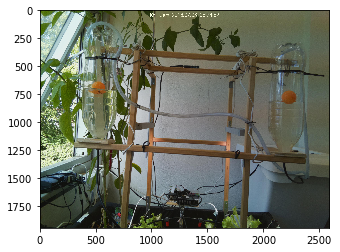

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # this is only used to present the output
import imageio

imgpath = "files/system_image.jpg"
# Read the image into a numpy array:
image = imageio.imread(imgpath)  

# image is a three-dimensional array (x-coordinates, y-coordinates, colours).
# Use `image.view()` to get a glimpse of what it looks like, or use pyplot to 
# display the image:
plt.imshow(image)

In [2]:
def plot(left, right, cmap=None):
    """
    Since we will be working on both tanks in parallel, we will display the output of both side-by-side.
    This function creates two subfigures and places them next to each other. 
    It's only a small helper.
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(left, cmap=cmap)
    ax1.set_title("Left tank")
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(right, cmap=cmap)
    ax2.set_title("Right tank")
    return ax1, ax2

### Cropping
Since we are only interested in sections of the image that are always static, we can crop it manually.


(<matplotlib.axes._subplots.AxesSubplot at 0x10dfd7978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e2232e8>)

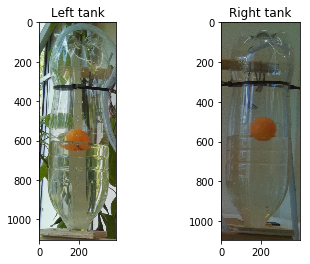

In [8]:
# These values were manually detected.
left_crop = dict(topleft=(330,96), bottomright=(720,1200))
right_crop = dict(topleft=(2015,240), bottomright=(2410,1335))

# We crop the image using the coordinates above to get two cropped sections
# containing the water tanks in the system.
cropped_image_left = image[left_crop["topleft"][1]:left_crop["bottomright"][1],
                        left_crop["topleft"][0]:left_crop["bottomright"][0], :]

cropped_image_right = image[right_crop["topleft"][1]:right_crop["bottomright"][1],
                        right_crop["topleft"][0]:right_crop["bottomright"][0], :]

# We plot the cropped sections.
plot(cropped_image_left, cropped_image_right)

### Red-Green filtering
To extract the orange pixels of the two balls in the cropped images, the green values of the pixels are subtracted from the red. This produces two greyscale images with high values in the regions where the balls are located, and lower ones everywhere else.


(<matplotlib.axes._subplots.AxesSubplot at 0x10e66e198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e7d4f28>)

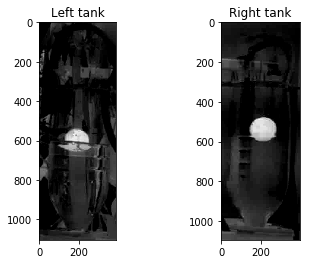

In [11]:
# The two cropped sections of the image are converted to integer values (from 0 to 255). 
cropped_image_left = cropped_image_left.astype(int)
cropped_image_right = cropped_image_right.astype(int)

# The green values of the pixels are subtracted from the red to get two filtered images.
# The filtered images are clipped between 0 and 255 to stay in the range of the greyscale colour map.
filtered_image_left = (cropped_image_left[:, :, 0] - cropped_image_left[:, :, 2]).clip(0, 255)
filtered_image_right = (cropped_image_right[:, :, 0] - cropped_image_right[:, :, 2]).clip(0, 255)

# We plot the filtered images.
plot(filtered_image_left, filtered_image_right, cmap='gray')

### Binarisation
To get two masks for the balls in the cropped sections of the original image, the filtered images obtained above are binarised. All the pixels with values below some selected threshold are set to zero (black), and the rest to one (white).

(<matplotlib.axes._subplots.AxesSubplot at 0x10f5b95c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10f677e10>)

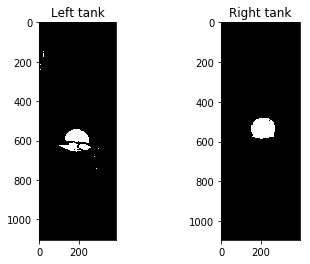

In [12]:
# A threshold is set with an arbitrary value that works well.
threshold = 80

# The images are binarised with this threshold.
binarised_left = filtered_image_left > threshold
binarised_right = filtered_image_right > threshold

# The resulting masks of the balls are plotted.
plot(binarised_left, binarised_right, cmap='gray')

### Median detection
To estimate the locations of the balls' centres in the masks, the median of the positions of the white pixels is computed in each binarised image.

Note how some pixels not belonging to the ball were set to one (white) during the binarisation process in the left image. Because we use the median value here (and not the mean), those pixels have almost no impact in the calculation of the position of the ball's centre.

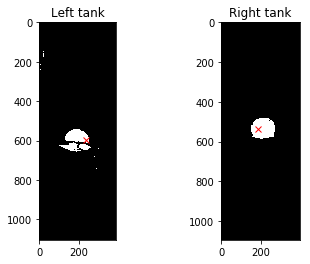

In [13]:
# The masks are first flattened to convert the 2D (cartesian) coordinates of their
# pixels to 1D indices.
flattened_left = np.reshape(binarised_left, np.product(binarised_left.shape))
flattened_right = np.reshape(binarised_right, np.product(binarised_right.shape))

# The median of the indices of white pixels is computed in each image.
ball_index_left = np.median(np.where(flattened_left))
ball_index_right = np.median(np.where(flattened_right))

# The median indices are then reconverted to 2D coordinates. The result is an estimate
# of the position of the ball's centre in each cropped image.
ball_center_left = np.unravel_index(int(ball_index_left), binarised_left.shape)[::-1]
ball_center_right = np.unravel_index(int(ball_index_right), binarised_right.shape)[::-1]

# The estimated positions of the balls' centres are plotted as red crosses 
# on the binary masks from before.
ax1, ax2 = plot(binarised_left, binarised_right, cmap='gray')
ax1.plot(ball_center_left[0], ball_center_left[1], 'rx')
ax2.plot(ball_center_right[0], ball_center_right[1], 'rx')

### Water level
The estimate the water level in each tank, the vertical position of the ball's centre in each cropped image is simply used. Because pixels' coordinates are numbered starting from the top of an image on the vertical axis, the estimated y position of a ball's centre corresponds to its distance from the superior border of the image. To get the distance from the bottom of a picture (i.e. the actual height of the ball), the y-coordinate of the ball is subtracted from the total height of the image. Once this is done, the obtained height can be used to represent the water level in the tank.

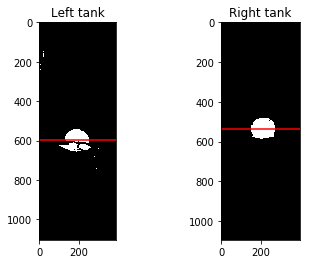

In [14]:
# The heights of the cropped sections of the image are retrieved.
(image_height_left, _, _) = cropped_image_left.shape
(image_height_right, _, _) = cropped_image_left.shape

# The balls' heights in the cropped sections are the number of pixels from the
# bottom of the images to the balls' centres.
ball_height_left = ball_center_left[1] - image_height_left
ball_height_right = ball_center_right[1] - image_height_right

# The estimated balls' heights are plotted as red lines on the binary masks.
ax1, ax2 = plot(binarised_left, binarised_right, cmap='gray')
ax1.axhline(y=ball_center_left[1], color='r')
ax2.axhline(y=ball_center_right[1], color='r')